## 0. Imports

In [421]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, ParameterGrid
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm
import pandas_ta as ta
import datetime
import itertools
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from xgboost import XGBRegressor, plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

## 1. Read data into Dataframe

In [2]:
df = pd.read_csv('../../long_short_local/raw_data/cleaned_data.csv')

## 2. Prepare data

### 2.1 Add SMA (simple moving average) for 10, 20 and 60 days

In [3]:
# convert 'Date' column to datetime values
df['Date'] = pd.to_datetime(df['Date'].str[:10])

In [4]:
sma_list = [10, 20, 60]

for sma in sma_list:
    if sma == 10:
        sma_10_df_prep = pd.DataFrame(df['Date'])

        for ratio in df.columns:
            test_df = df[['Date', ratio]]
            sma10 = pd.DataFrame(ta.sma(test_df[ratio], length=10))
            loop_df = pd.concat([test_df, sma10], axis=1, ignore_index=False)
            loop_df.rename(columns={'SMA_10': f'{ratio}_SMA_10'}, inplace=True)
            sma_10_df_prep = pd.concat([sma_10_df_prep, loop_df], axis=1, ignore_index=False)
            sma_10_df = sma_10_df_prep.iloc[:, 3:]
    
    elif sma == 20:
        sma_20_df_prep = pd.DataFrame(df['Date'])

        for ratio in df.columns:
            test_df = df[['Date', ratio]]
            sma20 = pd.DataFrame(ta.sma(test_df[ratio], length=20))
            loop_df = pd.concat([test_df, sma20], axis=1, ignore_index=False)
            loop_df.rename(columns={'SMA_20': f'{ratio}_SMA_20'}, inplace=True)
            sma_20_df_prep = pd.concat([sma_20_df_prep, loop_df], axis=1, ignore_index=False)
            sma_20_df = sma_20_df_prep.iloc[:, 3:]
    
    else:
        sma_60_df_prep = pd.DataFrame(df['Date'])

        for ratio in df.columns:
            test_df = df[['Date', ratio]]
            sma60 = pd.DataFrame(ta.sma(test_df[ratio], length=60))
            loop_df = pd.concat([test_df, sma60], axis=1, ignore_index=False)
            loop_df.rename(columns={'SMA_60': f'{ratio}_SMA_60'}, inplace=True)
            sma_60_df_prep = pd.concat([sma_60_df_prep, loop_df], axis=1, ignore_index=False)
            sma_60_df = sma_60_df_prep.iloc[:, 3:]

### 2.2 Add RSI (relative strength index) for 14 days

In [31]:
rsi_14_df_prep = pd.DataFrame(df['Date'])

for ratio in df.columns:
    test_df = df[['Date', ratio]]
    rsi14 = pd.DataFrame(ta.rsi(test_df[ratio], length=14))
    loop_df = pd.concat([test_df, rsi14], axis=1, ignore_index=False)
    loop_df.rename(columns={'RSI_14': f'{ratio}_RSI_14'}, inplace=True)
    rsi_14_df_prep = pd.concat([rsi_14_df_prep, loop_df], axis=1, ignore_index=False)
    rsi_14_df = rsi_14_df_prep.iloc[:, 3:]

### 2.3 Concatenate all 4 DFs

In [319]:
sorted_df

,ADP_SYK,ADP_SYK_RSI_14,ADP_SYK_SMA_10,ADP_SYK_SMA_20,ADP_SYK_SMA_60,APH_STE,APH_STE_RSI_14,APH_STE_SMA_10,APH_STE_SMA_20,APH_STE_SMA_60,...,TEL_BIO,TEL_BIO_RSI_14,TEL_BIO_SMA_10,TEL_BIO_SMA_20,TEL_BIO_SMA_60,TT_NEM,TT_NEM_RSI_14,TT_NEM_SMA_10,TT_NEM_SMA_20,TT_NEM_SMA_60
Date,,,,,,,,,,,,,,,,,,,,,
2022-02-23,0.771140,NaN,NaN,NaN,NaN,0.326856,NaN,NaN,NaN,NaN,...,0.239509,NaN,NaN,NaN,NaN,2.195844,NaN,NaN,NaN,NaN
2022-02-24,0.774126,NaN,NaN,NaN,NaN,0.326426,NaN,NaN,NaN,NaN,...,0.234301,NaN,NaN,NaN,NaN,2.280275,NaN,NaN,NaN,NaN
2022-02-25,0.766083,NaN,NaN,NaN,NaN,0.322575,NaN,NaN,NaN,NaN,...,0.223696,NaN,NaN,NaN,NaN,2.292504,NaN,NaN,NaN,NaN
2022-02-28,0.773484,NaN,NaN,NaN,NaN,0.315486,NaN,NaN,NaN,NaN,...,0.225564,NaN,NaN,NaN,NaN,2.339218,NaN,NaN,NaN,NaN
2022-03-01,0.767553,NaN,NaN,NaN,NaN,0.311195,NaN,NaN,NaN,NaN,...,0.217456,NaN,NaN,NaN,NaN,2.216707,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-17,1.177302,71.370360,1.153486,1.129509,1.060523,0.376317,71.130987,0.370512,0.353187,0.326485,...,0.258362,68.161378,0.249195,0.242021,0.237775,3.706459,85.439464,3.517020,3.304354,2.498414
2022-08-18,1.181579,72.283491,1.157752,1.134131,1.065004,0.376562,71.244974,0.370902,0.356096,0.327684,...,0.263737,71.660623,0.250940,0.243577,0.238229,3.739306,86.005048,3.548923,3.358520,2.528126
2022-08-19,1.191070,74.246225,1.162304,1.138439,1.069676,0.377388,71.650973,0.372062,0.358917,0.328950,...,0.264347,72.036201,0.252804,0.245116,0.238679,3.760855,86.378857,3.580269,3.411108,2.558894


In [312]:
concat_10_20_df = pd.concat([sma_10_df, sma_20_df], axis=1)
concat_10_20_60_df = pd.concat([concat_10_20_df, sma_60_df], axis=1)
combined_df = pd.concat([concat_10_20_60_df, rsi_14_df], axis=1)
# remove duplicates of 'Date' column
dropped_date_df = combined_df.loc[:,~combined_df.columns.duplicated()]
dropped_date_df.set_index('Date', inplace=True)
# sort the ratios by column name
sorted_df = dropped_date_df.reindex(sorted(dropped_date_df.columns, reverse=False), axis=1)

In [316]:
test_plot_df = sorted_df[['ADP_SYK', 'ADP_SYK_SMA_10', 'ADP_SYK_SMA_20', 'ADP_SYK_SMA_60']]

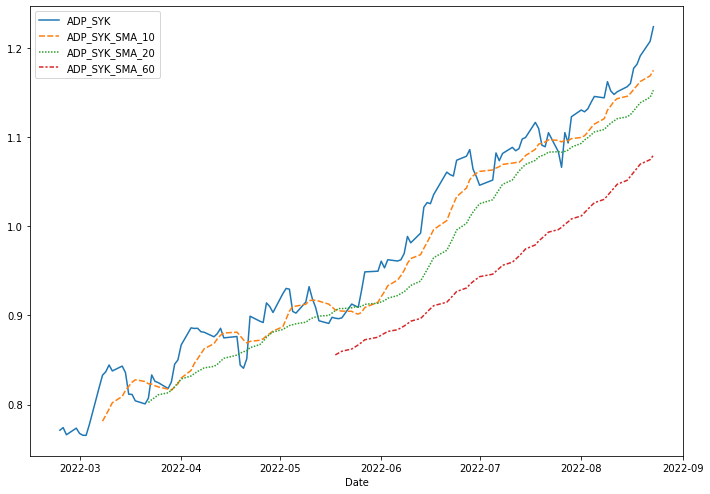

In [317]:
# test plot for the first ratio
dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dims)
sns.lineplot(data=test_plot_df.iloc[:, :5]);

- sorted_df contains all ratios with SMA for 10, 20, 60 days and RSI for 14 days. 
- We will load each time series to the XGBoost model separately
- But first, we need to create the features and labels

# Model test

### Prophet - Start

In [323]:
# reset index => 'Date' column becomes normal column in preparation for Prophet
prophet_df = sorted_df.reset_index()

In [330]:
# select first ratio for testing
pr_first_ratio_df = prophet_df.iloc[:, :6]

In [334]:
# rename 'Date' and ratio column
pr_first_ratio_df = pr_first_ratio_df.rename(columns={'ADP_SYK': 'y', 'Date': 'ds'})

In [352]:
# fill NaNs
pr_first_ratio_df = pr_first_ratio_df.fillna(pr_first_ratio_df.median())

/var/folders/9c/wqkq2b6j16l2hg0gd5_m7sj00000gn/T/ipykernel_34565/1516330283.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  pr_first_ratio_df = pr_first_ratio_df.fillna(pr_first_ratio_df.median())


In [354]:
# generate train and test sets
train_size = int(0.85 * pr_first_ratio_df.shape[0])
train_set = pr_first_ratio_df[:train_size]
test_set = pr_first_ratio_df[train_size:] 

In [359]:
# Prophet model
proph = Prophet(growth='linear', 
                yearly_seasonality=True,
                daily_seasonality=True)

proph.add_regressor('ADP_SYK_RSI_14')
proph.add_regressor('ADP_SYK_SMA_10')
proph.add_regressor('ADP_SYK_SMA_20')
proph.add_regressor('ADP_SYK_SMA_60')

proph.fit(train_set)

Initial log joint probability = -2.04207


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       521.292   4.84443e-05       471.526      0.2265      0.2265      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       523.448   0.000167625       862.777      0.6803      0.6803      218   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       530.068      0.045293       2675.71           1           1      326   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       535.345   4.94659e-05       230.963      0.7146      0.7146      432   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       535.817   1.90913e-05       97.2876      0.4589      0.4589      546   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599     

In [361]:
# create df that holds future values
future_df = proph.make_future_dataframe(periods=len(test_set),
                                        freq='D')

future_df.tail(1)

,ds
125,2022-08-15


In [366]:
# merge regressors
future_df = pd.concat([future_df,  pr_first_ratio_df.iloc[:, 2:]], axis=1)
future_df.head()

,ds,ADP_SYK_RSI_14,ADP_SYK_SMA_10,ADP_SYK_SMA_20,ADP_SYK_SMA_60
0,2022-02-23,66.931637,0.916992,0.924568,0.952728
1,2022-02-24,66.931637,0.916992,0.924568,0.952728
2,2022-02-25,66.931637,0.916992,0.924568,0.952728
3,2022-02-28,66.931637,0.916992,0.924568,0.952728
4,2022-03-01,66.931637,0.916992,0.924568,0.952728


In [381]:
# forecast
forecast = proph.predict(future_df)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,ADP_SYK_RSI_14,ADP_SYK_RSI_14_lower,ADP_SYK_RSI_14_upper,ADP_SYK_SMA_10,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
121,2022-08-11,1.059396,0.857837,0.869608,1.059360,1.059429,0.013264,0.013264,0.013264,-0.045480,...,0.003262,0.003262,0.003262,-0.224426,-0.224426,-0.224426,0.0,0.0,0.0,0.863582
122,2022-08-12,1.061026,0.823838,0.835427,1.060985,1.061063,0.015530,0.015530,0.015530,-0.046348,...,0.004270,0.004270,0.004270,-0.262656,-0.262656,-0.262656,0.0,0.0,0.0,0.829501
123,2022-08-13,1.062656,0.777886,0.789850,1.062610,1.062697,0.020399,0.020399,0.020399,-0.047273,...,-0.007057,-0.007057,-0.007057,-0.302296,-0.302296,-0.302296,0.0,0.0,0.0,0.784239
124,2022-08-14,1.064286,0.746079,0.757456,1.064235,1.064331,0.027789,0.027789,0.027789,-0.048562,...,-0.007057,-0.007057,-0.007057,-0.342851,-0.342851,-0.342851,0.0,0.0,0.0,0.751513
125,2022-08-15,1.065915,0.721903,0.733213,1.065860,1.065964,0.034113,0.034113,0.034113,-0.049816,...,0.003092,0.003092,0.003092,-0.383767,-0.383767,-0.383767,0.0,0.0,0.0,0.727501


In [388]:
proph_preds = forecast.yhat[train_size:].rename('prophet')

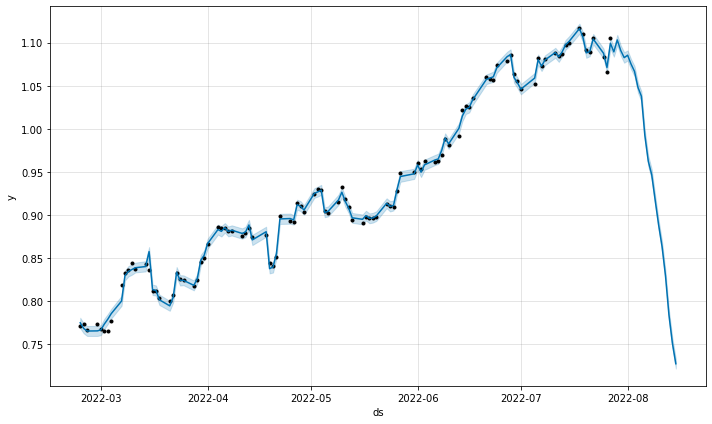

In [389]:
# visualise forecast
proph.plot(forecast);

In [393]:
# compute MAE and RMSE
print(round(mean_absolute_error(test_set['y'], proph_preds), 2))
print(round(mean_squared_error(test_set['y'], proph_preds), 2))

0.19
0.06


In [418]:
# compute MAPE
y_true, y_pred = np.array(test_set['y']), np.array(proph_preds)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [419]:
print(f'MAPE: {round(mape, 2)}')

MAPE: 16.11


In [406]:
# cross-validation
cv_df = cross_validation(proph,
                         horizon='20 days',
                         parallel='processes',
                         initial=20)

INFO:fbprophet:Making 14 forecasts with cutoffs between 2022-02-27 00:00:00 and 2022-07-07 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x14eb31c40>
INFO:fbprophet:n_changepoints greater than number of observations. Using 1.
INFO:fbprophet:n_changepoints greater than number of observations. Using 13.



Initial log joint probability = -130.175
Iteration  1. Log joint probability =    8.05051. Improved by 138.225.
Iteration  2. Log joint probability =    10.7535. Improved by 2.70294.
Iteration  3. Log joint probability =     12.654. Improved by 1.90059.
Iteration  4. Log joint probability =    15.3898. Improved by 2.73577.

Initial log joint probability = -116.334
Iteration  5. Log joint probability =    16.4349. Improved by 1.04509.
Iteration  1. Log joint probability =    23.0015. Improved by 139.336.
Iteration  6. Log joint probability =    18.9912. Improved by 2.55629.

Initial log joint probability = -119.951
Iteration  7. Log joint probability =    20.8576. Improved by 1.86637.
Iteration  2. Log joint probability =    35.8646. Improved by 12.8631.
Iteration  1. Log joint probability =    84.3785. Improved by 204.33.
Iteration  8. Log joint probability =    23.5991. Improved by 2.74151.
Iteration  3. Log joint probability =    48.8498. Improved by 12.9853.
Iteration  2. Log joint

INFO:fbprophet:n_changepoints greater than number of observations. Using 7.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.


Iteration 11. Log joint probability =    102.772. Improved by 1.12452.
Iteration  8. Log joint probability =    240.868. Improved by 1.38515.
Iteration 16. Log joint probability =    39.2209. Improved by 1.80183.
Iteration  9. Log joint probability =    240.874. Improved by 0.00616775.
Iteration  4. Log joint probability =    38.7501. Improved by 3.93163.
Iteration  6. Log joint probability =    186.281. Improved by 8.86298.
Iteration  1. Log joint probability =    40.9371. Improved by 149.888.
Iteration 10. Log joint probability =    240.882. Improved by 0.00818733.
Iteration  1. Log joint probability =    62.6246. Improved by 165.11.
Iteration 12. Log joint probability =    102.959. Improved by 0.187253.
Iteration 17. Log joint probability =    42.8438. Improved by 3.62288.
Iteration  5. Log joint probability =    163.795. Improved by 23.6061.
Iteration  2. Log joint probability =    54.8507. Improved by 13.9136.
Iteration  5. Log joint probability =     46.491. Improved by 7.74084.


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2022-02-28,-9.146846,-9.146846,-9.146846,0.773484,2022-02-27
1,2022-03-01,0.774466,0.774466,0.774466,0.767553,2022-02-27
2,2022-03-02,-1.139703,-1.139703,-1.139703,0.765541,2022-02-27
3,2022-03-03,-1.614676,-1.614676,-1.614675,0.765399,2022-02-27
4,2022-03-04,-2.026715,-2.026715,-2.026715,0.777620,2022-02-27


In [420]:
# evaluation
mae = round(mean_absolute_error(cv_df['y'], cv_df['yhat']), 2)
print(f'MAE: {round(mae, 2)}')
rmse = round(mean_squared_error(cv_df['y'], cv_df['yhat']), 2)
print(f'RMSE: {round(rmse, 2)}')
y_true, y_pred = np.array(cv_df['y']), np.array(cv_df['yhat'])
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f'MAPE: {round(mape, 2)}')

MAE: 2.06
RMSE: 19.54
MAPE: 238.33


In [423]:
# hyperparameter tuning
param_grid = {'seasonality_prior_scale': [5, 10, 20],
              'changepoint_prior_scale': [0.01, 0.05, 0.1]
             }

grid = ParameterGrid(param_grid)

In [424]:
rmse = []

for params in grid:
    # build model
    proph = Prophet(growth='linear', 
                yearly_seasonality=True,
                daily_seasonality=True,
                seasonality_prior_scale = params['seasonality_prior_scale'],
                changepoint_prior_scale = params['changepoint_prior_scale'])

    proph.add_regressor('ADP_SYK_RSI_14')
    proph.add_regressor('ADP_SYK_SMA_10')
    proph.add_regressor('ADP_SYK_SMA_20')
    proph.add_regressor('ADP_SYK_SMA_60')

    proph.fit(train_set)
    # cross-val
    cv_df = cross_validation(proph,
                         horizon='20 days',
                         parallel='processes',
                         initial=20)
    
    # get results
    error = mean_squared_error(cv_df['y'], cv_df['yhat'])
    rmse.append(error)

INFO:fbprophet:Making 14 forecasts with cutoffs between 2022-02-27 00:00:00 and 2022-07-07 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x150c55910>


Initial log joint probability = -2.04207
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       520.219   0.000569437       1181.72       1.684      0.1684      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       522.555   2.75383e-08       495.181      0.5245     0.05245      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       522.555   1.94597e-09       509.221      0.1986      0.1986      252   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.



Initial log joint probability = -71.8444
Iteration  1. Log joint probability =   -1.04009. Improved by 70.8043.

Initial log joint probability = -54.8044
Iteration  2. Log joint probability =    48.5388. Improved by 49.5789.
Iteration  1. Log joint probability =    40.9792. Improved by 95.7836.
Iteration  3. Log joint probability =    49.4636. Improved by 0.924813.
Iteration  2. Log joint probability =    55.1137. Improved by 14.1345.
Iteration  4. Log joint probability =    72.7527. Improved by 23.2891.
Iteration  3. Log joint probability =    63.3772. Improved by 8.26347.

Initial log joint probability = -56.1481
Iteration  4. Log joint probability =    83.6251. Improved by 20.2479.
Iteration  5. Log joint probability =    81.5371. Improved by 8.78448.
Iteration  5. Log joint probability =    94.4758. Improved by 10.8507.
Iteration  1. Log joint probability =    84.3915. Improved by 140.54.
Iteration  6. Log joint probability =    88.1105. Improved by 6.57339.
Iteration  7. Log join

INFO:fbprophet:n_changepoints greater than number of observations. Using 1.


Iteration 45. Log joint probability =    101.576. Improved by 3.90405e-07.
Iteration  3. Log joint probability =    176.509. Improved by 33.8979.
Iteration 25. Log joint probability =    118.842. Improved by 0.00511903.
Iteration 46. Log joint probability =    101.576. Improved by 9.89005e-08.
Iteration 26. Log joint probability =    118.845. Improved by 0.00295966.
Iteration 47. Log joint probability =    101.576. Improved by 9.80603e-08.
Iteration 48. Log joint probability =    101.576. Improved by 2.1698e-07.
Iteration  8. Log joint probability =    245.985. Improved by 0.166587.
Iteration 49. Log joint probability =    101.576. Improved by 6.27733e-08.
Iteration 27. Log joint probability =    118.845. Improved by 0.000186997.
Iteration  7. Log joint probability =    55.0857. Improved by 0.791084.
Iteration 50. Log joint probability =    101.576. Improved by 8.28297e-09.
Iteration  2. Log joint probability =    10.7169. Improved by 2.64402.
Iteration 28. Log joint probability =    1

INFO:fbprophet:Making 14 forecasts with cutoffs between 2022-02-27 00:00:00 and 2022-07-07 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x14f5cdb50>


Initial log joint probability = -2.04207
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       519.539    0.00666443       865.459           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       522.293   1.67707e-07       507.398           1           1      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       525.453   1.98806e-05       479.137           1           1      331   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     353       525.466   9.26615e-09       499.439      0.6995      0.6995      397   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.
INFO:fbprophet:n_changepoints greater than number of observations. Using 1.
INFO:fbprophet:n_changepoints greater than number of observations. Using 13.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.



Initial log joint probability = -112.446
Iteration  1. Log joint probability =    17.6435. Improved by 130.09.

Initial log joint probability = -128.565
Iteration  2. Log joint probability =    24.4255. Improved by 6.78201.
Iteration  1. Log joint probability =    8.05051. Improved by 136.616.
Iteration  2. Log joint probability =    10.7208. Improved by 2.67024.
Iteration  3. Log joint probability =    34.7182. Improved by 10.2927.
Iteration  3. Log joint probability =    12.6377. Improved by 1.91693.
Iteration  4. Log joint probability =    38.7338. Improved by 4.01556.

Initial log joint probability = -95.4114
Iteration  5. Log joint probability =    46.2766. Improved by 7.54279.
Iteration  4. Log joint probability =    15.3776. Improved by 2.73986.
Iteration  1. Log joint probability =    23.0015. Improved by 118.413.
Iteration  5. Log joint probability =    16.4144. Improved by 1.03689.
Iteration  6. Log joint probability =     50.387. Improved by 4.11048.
Iteration  7. Log joint

INFO:fbprophet:Making 14 forecasts with cutoffs between 2022-02-27 00:00:00 and 2022-07-07 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x150c42af0>


Initial log joint probability = -2.04207
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       520.697    0.00205274       793.855           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     197       524.692   6.19172e-09        505.95      0.2583      0.2583      226   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:n_changepoints greater than number of observations. Using 1.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 13.



Initial log joint probability = -152.132
Iteration  1. Log joint probability =    8.04476. Improved by 160.177.
Iteration  2. Log joint probability =    10.7217. Improved by 2.67696.

Initial log joint probability = -136.013
Iteration  3. Log joint probability =    12.6399. Improved by 1.91822.
Iteration  1. Log joint probability =    17.6352. Improved by 153.648.
Iteration  4. Log joint probability =    15.3949. Improved by 2.75497.
Iteration  2. Log joint probability =    24.4096. Improved by 6.77443.

Initial log joint probability = -101.938
Iteration  5. Log joint probability =    15.6621. Improved by 0.267228.
Iteration  3. Log joint probability =     34.813. Improved by 10.4034.
Iteration  6. Log joint probability =    19.1595. Improved by 3.49733.
Iteration  1. Log joint probability =    40.9193. Improved by 142.858.
Iteration  4. Log joint probability =    38.7466. Improved by 3.93354.
Iteration  7. Log joint probability =     21.002. Improved by 1.84258.
Iteration  5. Log joi

INFO:fbprophet:Making 14 forecasts with cutoffs between 2022-02-27 00:00:00 and 2022-07-07 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x14f69b610>


Initial log joint probability = -2.04207
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        520.75    0.00018643       363.401           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       524.026   0.000140337       646.743      0.3529      0.3529      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       526.539     0.0133445       2021.17      0.4346           1      335   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       531.892   0.000462728       419.958      0.7302      0.7302      443   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       533.858    0.00032499       242.147           1           1      550   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:fbprophet:n_changepoints greater than number of observations. Using 1.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.
INFO:fbprophet:n_changepoints greater than number of observations. Using 13.



Initial log joint probability = -106.608

Initial log joint probability = -78.9181
Iteration  1. Log joint probability =     8.0729. Improved by 114.68.
Iteration  2. Log joint probability =    10.7496. Improved by 2.67671.
Iteration  1. Log joint probability =     62.868. Improved by 141.786.
Iteration  3. Log joint probability =    12.6452. Improved by 1.89561.

Initial log joint probability = -100.145
Iteration  2. Log joint probability =    78.0046. Improved by 15.1366.
Iteration  4. Log joint probability =    14.8842. Improved by 2.23898.
Iteration  3. Log joint probability =     98.382. Improved by 20.3774.

Initial log joint probability = -92.7671
Iteration  5. Log joint probability =    17.8036. Improved by 2.91942.
Iteration  1. Log joint probability =     17.674. Improved by 117.819.
Iteration  6. Log joint probability =    19.7328. Improved by 1.92919.
Iteration  1. Log joint probability =   -1.04009. Improved by 91.727.
Iteration  4. Log joint probability =    105.967. Imp

INFO:fbprophet:n_changepoints greater than number of observations. Using 19.


Iteration 10. Log joint probability =    101.384. Improved by 0.034362.
Iteration 11. Log joint probability =    62.2244. Improved by 0.0164473.
Iteration 19. Log joint probability =    155.885. Improved by 0.0838388.
Iteration  5. Log joint probability =    214.928. Improved by 13.6157.
Iteration  6. Log joint probability =    159.602. Improved by 9.54831.
Iteration 20. Log joint probability =    155.899. Improved by 0.0139182.
Iteration 11. Log joint probability =    101.531. Improved by 0.14644.
Iteration 12. Log joint probability =    101.561. Improved by 0.0308215.
Iteration  6. Log joint probability =    215.057. Improved by 0.129925.
Iteration 12. Log joint probability =    62.2971. Improved by 0.0726709.
Iteration 16. Log joint probability =    40.3491. Improved by 1.57929.
Iteration  4. Log joint probability =    180.018. Improved by 18.6236.
Iteration  4. Log joint probability =    83.9372. Improved by 20.2491.
Iteration  7. Log joint probability =    165.698. Improved by 6.0

INFO:fbprophet:Making 14 forecasts with cutoffs between 2022-02-27 00:00:00 and 2022-07-07 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x150c4cdc0>


Initial log joint probability = -2.04207
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       521.292   4.84443e-05       471.526      0.2265      0.2265      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       523.448   0.000167625       862.777      0.6803      0.6803      218   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       530.068      0.045293       2675.71           1           1      326   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       535.345   4.94659e-05       230.963      0.7146      0.7146      432   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       535.817   1.90913e-05       97.2876      0.4589      0.4589      546   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:fbprophet:n_changepoints greater than number of observations. Using 1.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.



Initial log joint probability = -130.175
Iteration  1. Log joint probability =    8.05051. Improved by 138.225.
Iteration  2. Log joint probability =    10.7535. Improved by 2.70294.

Initial log joint probability = -114.434
Iteration  3. Log joint probability =     12.654. Improved by 1.90059.
Iteration  1. Log joint probability =    67.6531. Improved by 182.088.
Iteration  4. Log joint probability =    15.3898. Improved by 2.73577.
Iteration  5. Log joint probability =    16.4349. Improved by 1.04509.
Iteration  2. Log joint probability =    100.399. Improved by 32.7461.
Iteration  6. Log joint probability =    18.9912. Improved by 2.55629.

Initial log joint probability = -108.951
Iteration  3. Log joint probability =    123.903. Improved by 23.5042.
Iteration  7. Log joint probability =    20.8576. Improved by 1.86637.
Iteration  4. Log joint probability =    170.605. Improved by 46.7017.
Iteration  1. Log joint probability =    40.9371. Improved by 149.888.
Iteration  8. Log join

INFO:fbprophet:n_changepoints greater than number of observations. Using 13.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.



Initial log joint probability = -107.082
Iteration  9. Log joint probability =    120.375. Improved by 2.11151.
Iteration 13. Log joint probability =    33.6568. Improved by 3.36048.
Iteration 10. Log joint probability =    120.383. Improved by 0.00882235.
Iteration 11. Log joint probability =    120.424. Improved by 0.0404231.
Iteration  4. Log joint probability =    58.1498. Improved by 9.29993.
Iteration  1. Log joint probability =    84.3785. Improved by 204.33.
Iteration  3. Log joint probability =    89.7459. Improved by 15.514.
Iteration 12. Log joint probability =    120.545. Improved by 0.121127.
Iteration  2. Log joint probability =      24.54. Improved by 6.89647.
Iteration  1. Log joint probability =    63.3545. Improved by 170.437.
Iteration 11. Log joint probability =    200.386. Improved by 0.14879.
Iteration 13. Log joint probability =    120.752. Improved by 0.207369.
Iteration 14. Log joint probability =    120.875. Improved by 0.122777.
Iteration 12. Log joint proba

INFO:fbprophet:Making 14 forecasts with cutoffs between 2022-02-27 00:00:00 and 2022-07-07 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x14f69be50>


Initial log joint probability = -2.04207
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       522.718   0.000863422       430.869           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       524.327   0.000139799       218.322       2.623      0.2623      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       528.543    0.00889175       733.123           1           1      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       530.528    0.00345121       862.553           1           1      451   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       531.809   0.000824468        351.62       0.331           1      566   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:fbprophet:n_changepoints greater than number of observations. Using 7.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.



Initial log joint probability = -147.279
Iteration  1. Log joint probability =    17.6352. Improved by 164.915.
Iteration  2. Log joint probability =    24.5241. Improved by 6.88889.
Iteration  3. Log joint probability =    34.9134. Improved by 10.3893.
Iteration  4. Log joint probability =    38.7632. Improved by 3.84987.
Iteration  5. Log joint probability =    45.8545. Improved by 7.09125.
Iteration  6. Log joint probability =    52.3531. Improved by 6.4986.
Iteration  7. Log joint probability =    52.9977. Improved by 0.644609.
Iteration  8. Log joint probability =    56.0021. Improved by 3.00442.
Iteration  9. Log joint probability =    70.4894. Improved by 14.4873.

Initial log joint probability = -132.518
Iteration 10. Log joint probability =    70.4984. Improved by 0.00899902.
Iteration  1. Log joint probability =    40.9193. Improved by 173.437.
Iteration 11. Log joint probability =    70.5006. Improved by 0.0022489.
Iteration  2. Log joint probability =    54.5407. Improved 

INFO:fbprophet:n_changepoints greater than number of observations. Using 13.
INFO:fbprophet:n_changepoints greater than number of observations. Using 1.


Iteration  8. Log joint probability =    114.358. Improved by 3.06617.
Iteration  3. Log joint probability =    114.196. Improved by 10.9461.
Iteration 17. Log joint probability =    90.9395. Improved by 1.55544.
Iteration  5. Log joint probability =    54.6474. Improved by 3.10265.
Iteration  9. Log joint probability =    115.347. Improved by 0.989726.
Iteration  2. Log joint probability =    10.7544. Improved by 2.70965.
Iteration  6. Log joint probability =    63.4807. Improved by 8.8333.
Iteration 10. Log joint probability =    115.455. Improved by 0.10796.
Iteration 18. Log joint probability =    90.9472. Improved by 0.00770811.
Iteration  3. Log joint probability =    12.6563. Improved by 1.90187.

Initial log joint probability = -138.001

Initial log joint probability = -143.518
Iteration  4. Log joint probability =    137.682. Improved by 23.4864.
Iteration 19. Log joint probability =    91.0076. Improved by 0.0604235.
Iteration  7. Log joint probability =     71.887. Improved 

INFO:fbprophet:Making 14 forecasts with cutoffs between 2022-02-27 00:00:00 and 2022-07-07 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x150c61970>


Initial log joint probability = -2.04207
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       520.162    0.00417556       1378.92           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       523.495   0.000150651       227.451           1           1      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       527.133    0.00223929        815.52      0.2062           1      333   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        531.85   0.000253457       615.491           1           1      441   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       533.772   3.90041e-05       295.233      0.3339      0.3339      548   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:fbprophet:n_changepoints greater than number of observations. Using 1.
INFO:fbprophet:n_changepoints greater than number of observations. Using 13.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.



Initial log joint probability = -107.301
Iteration  1. Log joint probability =     8.0729. Improved by 115.374.

Initial log joint probability = -101.778
Iteration  2. Log joint probability =    10.7537. Improved by 2.6808.
Iteration  1. Log joint probability =   -1.04009. Improved by 100.738.
Iteration  3. Log joint probability =    12.6473. Improved by 1.89357.
Iteration  2. Log joint probability =    49.0219. Improved by 50.062.

Initial log joint probability = -100.844
Iteration  4. Log joint probability =    14.8857. Improved by 2.23846.
Iteration  3. Log joint probability =    49.3448. Improved by 0.322935.
Iteration  5. Log joint probability =    17.8062. Improved by 2.92046.
Iteration  4. Log joint probability =    73.2374. Improved by 23.8926.
Iteration  1. Log joint probability =    63.8132. Improved by 164.657.
Iteration  6. Log joint probability =    19.7333. Improved by 1.92715.
Iteration  5. Log joint probability =    81.6973. Improved by 8.45992.

Initial log joint prob

INFO:fbprophet:n_changepoints greater than number of observations. Using 19.


Iteration  8. Log joint probability =    154.541. Improved by 0.00232596.
Iteration 15. Log joint probability =    107.679. Improved by 0.0105731.
Iteration  5. Log joint probability =    215.043. Improved by 13.7599.
Iteration  4. Log joint probability =    83.9779. Improved by 20.2506.
Iteration  6. Log joint probability =    215.429. Improved by 0.386234.
Iteration 10. Log joint probability =    57.2511. Improved by 0.260612.
Iteration 13. Log joint probability =    175.641. Improved by 0.00569056.
Iteration 17. Log joint probability =    44.7176. Improved by 2.74509.
Iteration  7. Log joint probability =     215.44. Improved by 0.0114085.
Iteration  9. Log joint probability =    156.101. Improved by 1.56013.
Iteration  3. Log joint probability =    161.407. Improved by 43.6102.
Iteration 11. Log joint probability =    57.4825. Improved by 0.231363.
Iteration 12. Log joint probability =    57.4883. Improved by 0.00586432.
Iteration 16. Log joint probability =    107.683. Improved by

INFO:fbprophet:Making 14 forecasts with cutoffs between 2022-02-27 00:00:00 and 2022-07-07 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x150c4c850>


Initial log joint probability = -2.04207
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       519.095    0.00166314       831.941           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        521.95    0.00395868       716.664           1           1      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       529.277   0.000346948       219.297           1           1      333   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       531.299   0.000571642       296.963      0.4802           1      440   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       533.506    0.00209692        363.09      0.2195           1      554   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:fbprophet:n_changepoints greater than number of observations. Using 7.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.



Initial log joint probability = -128.564

Initial log joint probability = -122.12
Iteration  1. Log joint probability =    17.6435. Improved by 146.208.
Iteration  2. Log joint probability =    24.5543. Improved by 6.91081.
Iteration  1. Log joint probability =    40.9371. Improved by 163.058.
Iteration  3. Log joint probability =    34.8312. Improved by 10.2769.

Initial log joint probability = -137.28
Iteration  4. Log joint probability =    38.7545. Improved by 3.92327.
Iteration  2. Log joint probability =    54.8896. Improved by 13.9524.
Iteration  1. Log joint probability =    84.3785. Improved by 221.658.
Iteration  5. Log joint probability =    46.5176. Improved by 7.76308.
Iteration  3. Log joint probability =    64.7624. Improved by 9.8728.

Initial log joint probability = -119.814
Iteration  4. Log joint probability =    84.4925. Improved by 19.7301.
Iteration  6. Log joint probability =    50.5616. Improved by 4.04408.
Iteration  2. Log joint probability =    117.848. Impr

INFO:fbprophet:n_changepoints greater than number of observations. Using 1.
INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Iteration  6. Log joint probability =      73.45. Improved by 11.3419.
Iteration 10. Log joint probability =    162.012. Improved by 0.0153232.
Iteration  8. Log joint probability =    23.5999. Improved by 2.74187.
Iteration 15. Log joint probability =    120.083. Improved by 0.127976.
Iteration  2. Log joint probability =    104.859. Improved by 41.5041.
Iteration 17. Log joint probability =    66.3435. Improved by 0.0168026.
Iteration  4. Log joint probability =    170.695. Improved by 46.7794.
Iteration  7. Log joint probability =    86.2331. Improved by 12.7831.
Iteration 16. Log joint probability =    120.205. Improved by 0.121434.
Iteration 11. Log joint probability =    242.272. Improved by 0.286641.
Iteration 17. Log joint probability =    120.337. Improved by 0.132004.
Iteration  9. Log joint probability =    25.6834. Improved by 2.08348.
Iteration 18. Log joint probability =    66.4538. Improved by 0.11032.
Iteration  5. Log joint probability =    177.461. Improved by 6.76623

INFO:fbprophet:Making 14 forecasts with cutoffs between 2022-02-27 00:00:00 and 2022-07-07 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x14f69bd30>


Initial log joint probability = -2.04207
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       523.353    0.00117012       625.859           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       526.516    0.00347828       353.585      0.4776           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       530.541   0.000669071       301.602           1           1      337   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       531.867   3.06702e-05       104.538           1           1      443   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       533.171    0.00103668       816.205       0.458           1      551   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:fbprophet:n_changepoints greater than number of observations. Using 1.



Initial log joint probability = -154.435
Iteration  1. Log joint probability =    8.04476. Improved by 162.479.
Iteration  2. Log joint probability =    10.7585. Improved by 2.71374.
Iteration  3. Log joint probability =    12.6583. Improved by 1.89982.
Iteration  4. Log joint probability =    15.4087. Improved by 2.75037.
Iteration  5. Log joint probability =    15.6852. Improved by 0.276505.
Iteration  6. Log joint probability =    19.1732. Improved by 3.48804.

Initial log joint probability = -143.381
Iteration  1. Log joint probability =    62.4042. Improved by 205.785.
Iteration  7. Log joint probability =    21.0067. Improved by 1.83344.

Initial log joint probability = -147.978
Iteration  8. Log joint probability =    21.0986. Improved by 0.0918962.
Iteration  2. Log joint probability =    70.2138. Improved by 7.80961.
Iteration  1. Log joint probability =    62.8591. Improved by 210.837.
Iteration  9. Log joint probability =    24.7805. Improved by 3.68195.

Initial log joint 

INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.
INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


Iteration 17. Log joint probability =    38.9004. Improved by 1.88596.
Iteration 18. Log joint probability =     40.757. Improved by 1.8566.
Iteration  3. Log joint probability =    64.5838. Improved by 10.0042.
Iteration  9. Log joint probability =    179.144. Improved by 0.327249.
Iteration  2. Log joint probability =    24.5384. Improved by 6.90323.

Initial log joint probability = -148.912
Iteration  6. Log joint probability =    177.962. Improved by 7.47828.
Iteration 11. Log joint probability =    161.387. Improved by 0.0129595.
Iteration 10. Log joint probability =    179.953. Improved by 0.809156.
Iteration 12. Log joint probability =    161.702. Improved by 0.315536.
Iteration  4. Log joint probability =    82.5526. Improved by 17.9688.
Iteration 19. Log joint probability =    44.0179. Improved by 3.26082.
Iteration  3. Log joint probability =    34.9261. Improved by 10.3877.
Iteration  1. Log joint probability =    22.9958. Improved by 171.908.

Initial log joint probability 

In [425]:
# best parameters
best_params = grid[np.argmin(rmse)]
print(best_params)

{'seasonality_prior_scale': 5, 'changepoint_prior_scale': 0.01}


In [426]:
# final model
proph = Prophet(growth='linear', 
            yearly_seasonality=True,
            daily_seasonality=True,
            seasonality_prior_scale = best_params['seasonality_prior_scale'],
            changepoint_prior_scale = best_params['changepoint_prior_scale'])

proph.add_regressor('ADP_SYK_RSI_14')
proph.add_regressor('ADP_SYK_SMA_10')
proph.add_regressor('ADP_SYK_SMA_20')
proph.add_regressor('ADP_SYK_SMA_60')

proph.fit(train_set)

Initial log joint probability = -2.04207


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       520.219   0.000569437       1181.72       1.684      0.1684      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       522.555   2.75383e-08       495.181      0.5245     0.05245      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       522.555   1.94597e-09       509.221      0.1986      0.1986      252   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


In [427]:
future_df = proph.make_future_dataframe(periods=len(test_set),
                                        freq='D')
future_df = pd.concat([future_df,  pr_first_ratio_df.iloc[:, 2:]], axis=1)
future_df.head()
future_df.tail(1)

,ds,ADP_SYK_RSI_14,ADP_SYK_SMA_10,ADP_SYK_SMA_20,ADP_SYK_SMA_60
125,2022-08-15,79.774497,1.174809,1.152509,1.079578


In [428]:
# forecast
forecast = proph.predict(future_df)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,ADP_SYK_RSI_14,ADP_SYK_RSI_14_lower,ADP_SYK_RSI_14_upper,ADP_SYK_SMA_10,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
121,2022-08-11,1.140824,1.210366,1.222162,1.140824,1.140824,0.013903,0.013903,0.013903,-0.054760,...,0.001494,0.001494,0.001494,0.081840,0.081840,0.081840,0.0,0.0,0.0,1.216267
122,2022-08-12,1.142998,1.218877,1.230142,1.142998,1.142998,0.016277,0.016277,0.016277,-0.055804,...,0.002267,0.002267,0.002267,0.085064,0.085064,0.085064,0.0,0.0,0.0,1.224337
123,2022-08-13,1.145171,1.223838,1.234973,1.145171,1.145171,0.021381,0.021381,0.021381,-0.056918,...,-0.001953,-0.001953,-0.001953,0.087682,0.087682,0.087682,0.0,0.0,0.0,1.229477
124,2022-08-14,1.147345,1.234113,1.245896,1.147345,1.147345,0.029126,0.029126,0.029126,-0.058469,...,-0.001953,-0.001953,-0.001953,0.089594,0.089594,0.089594,0.0,0.0,0.0,1.240415
125,2022-08-15,1.149518,1.246737,1.257900,1.149518,1.149518,0.035756,0.035756,0.035756,-0.059980,...,0.000832,0.000832,0.000832,0.090709,0.090709,0.090709,0.0,0.0,0.0,1.252306


In [433]:
# extract predictions
proph_preds_tuned = forecast.yhat[train_size:].rename('prophet_tuned')
proph_preds_tuned.index = test_set['ds']

### Prophet - End

### XGBoost - Start

In [437]:
ratio_df[['Date', 'ADP_SYK', '5d_future_close']].head(16)

,Date,ADP_SYK,5d_future_close
0,2022-02-23,0.771140,0.765541
1,2022-02-24,0.774126,0.765399
2,2022-02-25,0.766083,0.777620
3,2022-02-28,0.773484,0.819354
4,2022-03-01,0.767553,0.832825
5,2022-03-02,0.765541,0.836789
6,2022-03-03,0.765399,0.844340
7,2022-03-04,0.777620,0.837656
8,2022-03-07,0.819354,0.843098
9,2022-03-08,0.832825,0.835860


In [187]:
ratio_df = sorted_df.iloc[:, :5]

In [188]:
# add price features
# the new column contains the %age change of each day compared to the prior 5 days
ratio_df['5d_close_pct'] = ratio_df['ADP_SYK'].pct_change(5)

/var/folders/9c/wqkq2b6j16l2hg0gd5_m7sj00000gn/T/ipykernel_34565/1049723737.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratio_df['5d_close_pct'] = ratio_df['ADP_SYK'].pct_change(5)


In [189]:
ratio_df['5d_future_close'] = ratio_df['ADP_SYK'].shift(-5)

/var/folders/9c/wqkq2b6j16l2hg0gd5_m7sj00000gn/T/ipykernel_34565/2985685657.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratio_df['5d_future_close'] = ratio_df['ADP_SYK'].shift(-5)


In [190]:
ratio_df['5d_future_close_pct'] = ratio_df['5d_future_close'].pct_change(5)

/var/folders/9c/wqkq2b6j16l2hg0gd5_m7sj00000gn/T/ipykernel_34565/1482787446.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratio_df['5d_future_close_pct'] = ratio_df['5d_future_close'].pct_change(5)


In [191]:
# add datetime features and concatenate with ratio_df
days_of_week = pd.get_dummies(ratio_df.index.dayofweek, prefix='weekday', drop_first=True)
ratio_df = pd.concat([ratio_df.reset_index(), days_of_week], axis=1, ignore_index=False)

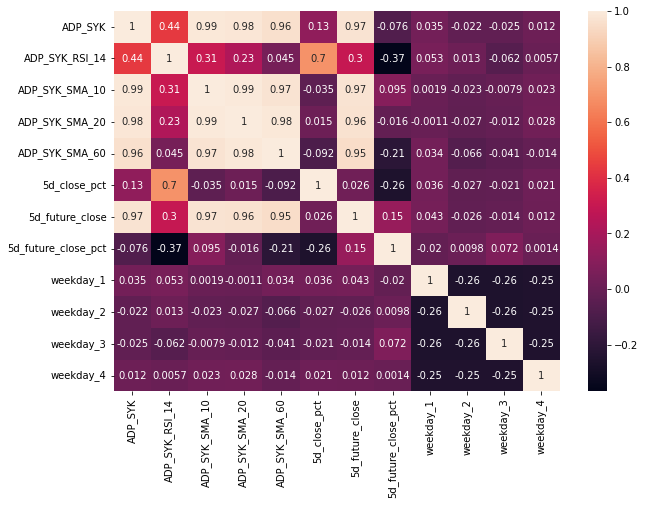

In [192]:
corr1 = ratio_df.corr()
dims = (10, 7)
fig, ax = plt.subplots(figsize=dims)
sns.heatmap(corr1, annot=True, fmt='.2g');

In [247]:
# extract features for modelling
feature_names = ['5d_close_pct', 'ADP_SYK_SMA_10', 'ADP_SYK_SMA_20', 'ADP_SYK_SMA_60', 'ADP_SYK_RSI_14', 
                 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4']
features = ratio_df[feature_names]
targets = ratio_df['5d_future_close_pct']

In [197]:
feature_target_df = pd.concat([ratio_df[feature_names], ratio_df['5d_future_close_pct']], axis=1)

In [250]:
# make train and test sets
#linear_features = sm.add_constant(features)
linear_features = features.fillna(features.median())
target_median = targets.median()
targets.fillna(target_median, inplace=True)

train_size = int(0.85 * targets.shape[0])
X_train = linear_features[:train_size]
y_train = targets[:train_size]
X_test = linear_features[train_size:]
y_test = targets[train_size:]

In [254]:
# build the XGBoost model
xgb_reg = XGBRegressor(booster='gbtree',
                       objective='reg:squarederror',
                       max_depth=3,
                       n_estimators=100,
                       learning_rate=0.1,
                       n_jobs=-1,
                       random_state=2)

In [255]:
# fit the model
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=-1,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=2, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

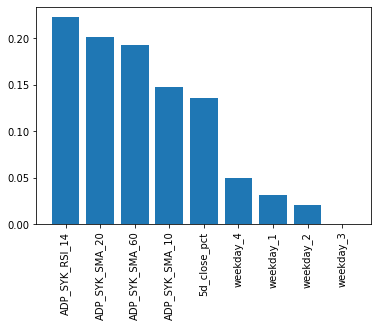

In [259]:
# check feature importances
importances = xgb_reg.feature_importances_
sorted_index = np.argsort(importances)[::-1]
x = range(len(importances))
labels = np.array(feature_names)[sorted_index]
plt.bar(x, importances[sorted_index], tick_label=labels)
plt.xticks(rotation=90)
plt.show()

In [278]:
# make a 5 day prediction
y_pred = pd.Series(xgb_reg.predict(X_test), name='XGBoost')
y_pred.index = ratio_df.Date[train_size:]

In [279]:
y_pred

Date
2022-07-28    0.023331
2022-07-29    0.023898
2022-08-01    0.019450
2022-08-02    0.018176
2022-08-03    0.013803
2022-08-04    0.019902
2022-08-05    0.022547
2022-08-08    0.028720
2022-08-09    0.003909
2022-08-10    0.015435
2022-08-11    0.023331
2022-08-12    0.024916
2022-08-15    0.023784
2022-08-16    0.023212
2022-08-17   -0.002251
2022-08-18   -0.006561
2022-08-19   -0.004613
2022-08-22   -0.005010
2022-08-23   -0.007034
Name: XGBoost, dtype: float32

### XGBoost - End

# Model test

DO NOT CHANGE !

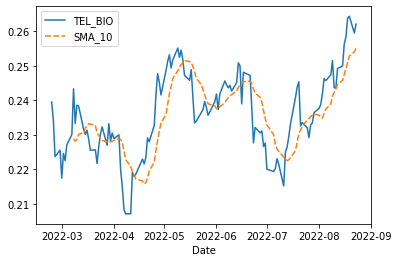

In [6]:
df = pd.read_csv('../../long_short_local/raw_data/cleaned_data.csv')
# convert 'Date' column to datetime values
df['Date'] = pd.to_datetime(df['Date'].str[:10])

test_df = df[['Date', 'TEL_BIO']]
sma10 = pd.DataFrame(ta.sma(test_df["TEL_BIO"], length=10))
tel_bio_df = pd.concat([test_df, sma10], axis=1, ignore_index=False)
tel_bio_df.set_index('Date', inplace=True)
sns.lineplot(data=tel_bio_df);

DO NOT CHANGE !

In [7]:
# convert 'Date' column to datetime values
df['Date'] = pd.to_datetime(df['Date'].str[:10])

AttributeError: Can only use .str accessor with string values!

In [ ]:
# split into 'train' and 'test' data
split_date = df['Date'][41]
df.set_index('Date', inplace=True)
train_df = df.loc[df.index <= split_date].copy()
test_df = df.loc[df.index > split_date].copy()

In [ ]:
def create_features(df, label=None):
    df['date'] = df.index
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.weekofyear

    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [ ]:
X_train, y_train = create_features(train_df, label='number')

In [ ]:
X_test, y_test = create_features(test_df, label='number')

In [ ]:
# build first model
model = XGBRegressor(n_estimators=1000)

In [ ]:
model.fit()